In [ ]:
#Q1-1
#professor canceled this part

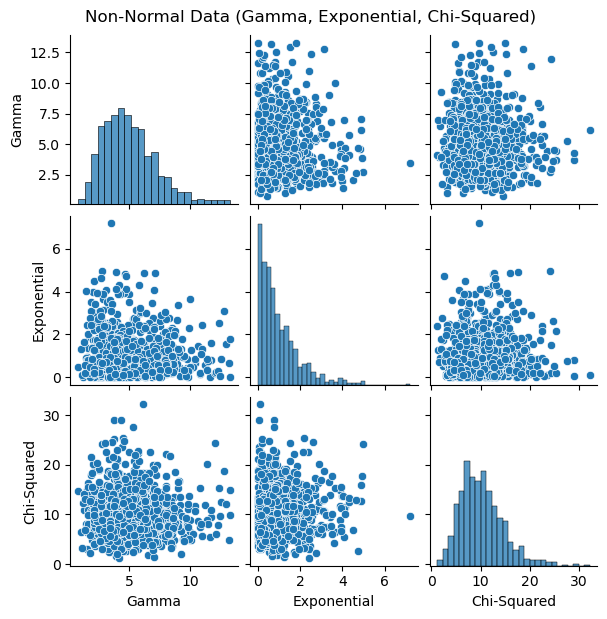

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, beta, nu]


Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 1 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


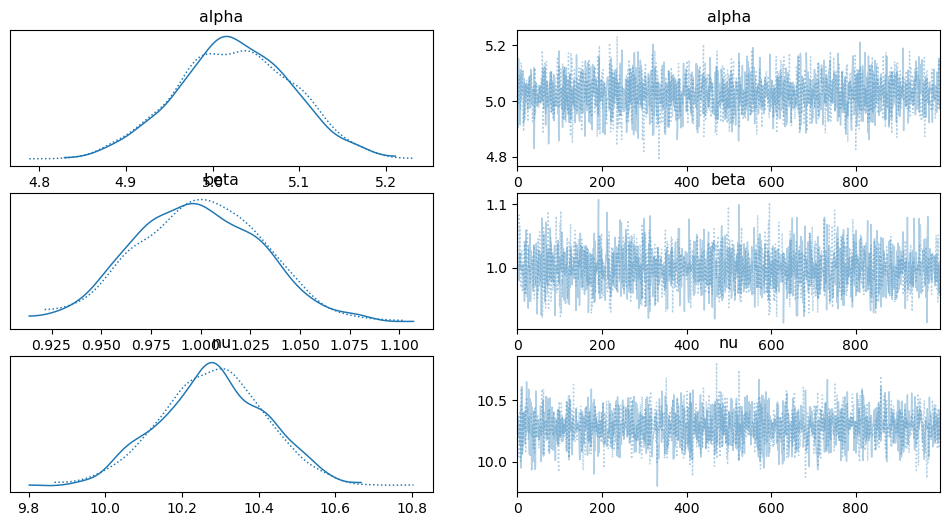

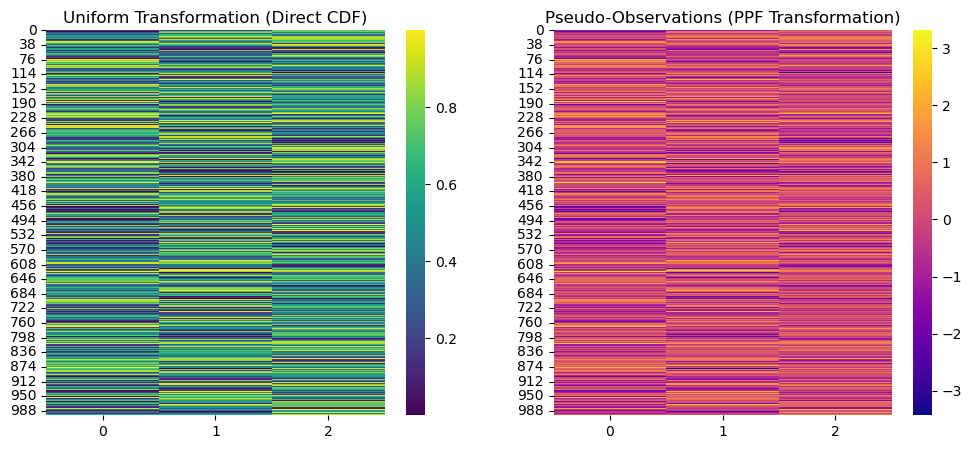

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [R]


Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 33 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
/opt/conda/lib/python3.11/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/opt/conda/lib/python3.11/site-packages/arviz/stats/diagnostics.py:991: RuntimeWarning: invalid value encountered in scalar divide
  varsd = varvar / evar / 4
/opt/conda/lib/python3.11/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/opt/conda/lib/python3.11/site-packages/arviz/stats/density_utils.py:700: RuntimeWarning: divide by zero encountered in divide
  f = grid_counts / bin_width / len(x)
/opt/conda/lib/python3.11/site-packages/

               mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
R[0]          0.575  0.013   0.550    0.599        0.0      0.0    1467.0   
R[1]          0.435  0.015   0.405    0.463        0.0      0.0    1601.0   
R[2]          0.387  0.009   0.371    0.405        0.0      0.0    1883.0   
R[3]          0.443  0.016   0.414    0.472        0.0      0.0    1533.0   
R[4]          0.197  0.012   0.176    0.218        0.0      0.0    1871.0   
R[5]          0.334  0.008   0.321    0.350        0.0      0.0    1853.0   
R_corr[0, 0]  1.000  0.000   1.000    1.000        0.0      NaN    2000.0   
R_corr[0, 1]  0.747  0.014   0.721    0.773        0.0      0.0    1650.0   
R_corr[0, 2]  0.752  0.014   0.727    0.779        0.0      0.0    1445.0   
R_corr[1, 0]  0.747  0.014   0.721    0.773        0.0      0.0    1650.0   
R_corr[1, 1]  1.000  0.000   1.000    1.000        0.0      0.0    1911.0   
R_corr[1, 2]  0.784  0.012   0.759    0.806        0.0      0.0    1815.0   

OverflowError: cannot convert float infinity to integer

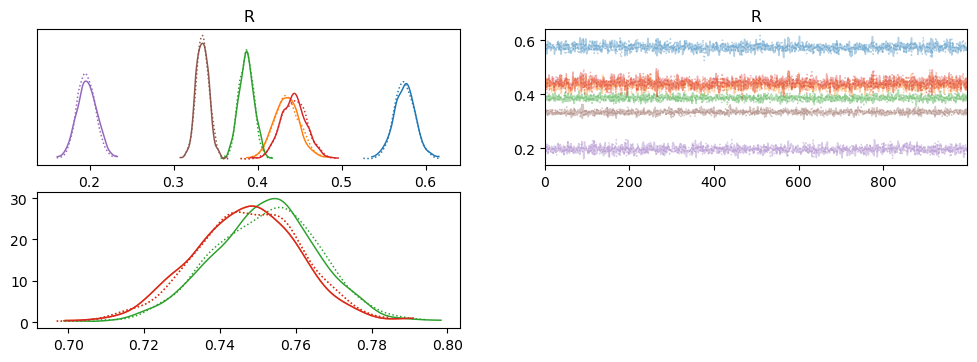

In [2]:
#Q1-2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gamma, expon, chi2, norm
import pymc as pm
import arviz as az

np.random.seed(1007818630)

# Generate non-normal data
n = 1000
data = np.column_stack([
    gamma(a=5).rvs(n),        
    expon(scale=1).rvs(n),    
    chi2(df=10).rvs(n)        
])

# Convert to DataFrame for visualization
df = pd.DataFrame(data, columns=["Gamma", "Exponential", "Chi-Squared"])

# Visualize the raw data
sns.pairplot(df, height=2)
plt.suptitle("Non-Normal Data (Gamma, Exponential, Chi-Squared)", y=1.02)
plt.show()

# Fit Marginal Distributions Independently (First Pass)
with pm.Model() as marginal_model:
    # Gamma distribution for the first variable
    alpha = pm.HalfNormal('alpha', sigma=10)
    gamma_dist = pm.Gamma('gamma_dist', alpha=alpha, beta=1, observed=data[:, 0])
    
    # Exponential distribution for the second variable
    beta = pm.HalfNormal('beta', sigma=10)
    expon_dist = pm.Exponential('expon_dist', lam=beta, observed=data[:, 1])
    
    # Chi-squared distribution for the third variable
    nu = pm.HalfNormal('nu', sigma=10)
    chi2_dist = pm.ChiSquared('chi2_dist', nu=nu, observed=data[:, 2])
    
    # Sampling from the marginal distributions
    marginal_idata = pm.sample(draws=1000, tune=500, chains=2, cores=2)

# Visualize the marginal distribution fitting
az.plot_trace(marginal_idata)
plt.show()

# Direct Uniform Transformation using CDF
uniform_data = np.column_stack([
    gamma.cdf(data[:, 0], a=5),    # Gamma CDF
    expon.cdf(data[:, 1], scale=1), # Exponential CDF
    chi2.cdf(data[:, 2], df=10)     # Chi-squared CDF
])

# Pseudo-Observation Transformation using Posterior Means
p0_mean = az.summary(marginal_idata, var_names=['alpha'])['mean'].values[0]
p1_mean = az.summary(marginal_idata, var_names=['beta'])['mean'].values[0]
p2_mean = az.summary(marginal_idata, var_names=['nu'])['mean'].values[0]

u0 = gamma.cdf(data[:, 0], a=p0_mean)
z0 = norm.ppf(u0)

u1 = expon.cdf(data[:, 1], scale=1/p1_mean)
z1 = norm.ppf(u1)

u2 = chi2.cdf(data[:, 2], df=p2_mean)
z2 = norm.ppf(u2)

# Combine the pseudo-observations into a single matrix
pseudo_observations = np.column_stack([z0, z1, z2])

# Compare the two transformations visually
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(uniform_data, ax=axes[0], cmap="viridis")
axes[0].set_title("Uniform Transformation (Direct CDF)")
sns.heatmap(pseudo_observations, ax=axes[1], cmap="plasma")
axes[1].set_title("Pseudo-Observations (PPF Transformation)")
plt.show()

# Fit the Copula Model (Second Pass)
with pm.Model() as copula_model:
    # LKJ Cholesky Covariance Prior
    L, R, stds = pm.LKJCholeskyCov(
        "R", n=3, eta=2.0, sd_dist=pm.Exponential.dist(1.0)
    )
    # Multivariate Normal Copula with Cholesky decomposition
    copula = pm.MvNormal("copula", mu=np.zeros(3), chol=L, observed=uniform_data)
    
    # Sampling from the copula model
    copula_idata = pm.sample(draws=1000, tune=500, chains=2, cores=2)

print(az.summary(copula_idata))

az.plot_trace(copula_idata)
plt.show()

az.plot_posterior(copula_idata)
plt.show()

# Posterior Pair Plot
az.plot_pair(copula_idata, kind="kde", marginals=True)
plt.show()

#### Q1-3
A copula is a function that links univariate marginal distributions to form a full multivariate distribution, allowing for flexible modeling of complex dependencies while preserving individual distribution characteristics. According to Sklar’s Theorem, any multivariate distribution can be expressed as a combination of its marginals and a copula that binds them together, making copulas useful for modeling dependencies independently of the marginals.  

In the one-pass approach (direct fitting), the model jointly estimates both marginal parameters and the latent correlation structure within a single model through deterministic transformations. This approach is theoretically superior because it captures full posterior uncertainty and maintains consistent dependency modeling. However, it is computationally intensive and prone to slow convergence, especially in high-dimensional settings.  

The two-pass approach first estimates the marginal distributions independently and then transforms the observed data to a common (usually Gaussian) scale using the inverse cumulative distribution function (or PPF). A separate model then estimates the dependency structure using an LKJ prior on the correlation matrix, implementing a Gaussian copula. This approach reduces computational complexity, making it faster and more efficient for large datasets, but it sacrifices some accuracy by treating marginal and dependency estimation as separate processes, which may underestimate joint variability.  

While the one-pass approach is theoretically more robust and accurate in capturing the full joint posterior distribution, it is often impractical due to its computational demands. The two-pass approach, despite its limitations in fully capturing parameter uncertainty, is more feasible for real-world applications due to its computational efficiency.

#### Q1-4
By using copulas, we can separate marginal model specification from the dependency structure, allowing for flexible construction of multivariate generalized linear models (GLMs) with different outcome types. This flexibility is useful for building complex models that capture both individual response behavior and interdependencies. Each response variable can be modeled independently using an appropriate GLM structure, considering its distribution and link function. After fitting the independent GLMs, residuals or predictions are transformed to a common scale using the inverse cumulative distribution function, obtaining uniform or normal scores. These transformed scores are then used in the copula modeling step, where a Gaussian copula with an LKJ prior on the correlation matrix captures the joint dependency. This approach leverages the full Bayesian framework for uncertainty quantification while maintaining flexibility in specifying the marginal models.  

The direct copula approach models the entire joint distribution directly, integrating marginal and dependency modeling into one unified framework. This method is theoretically superior because it captures full posterior uncertainty and maintains consistent dependency modeling, but it is computationally expensive and prone to numerical instability. In contrast, the two-pass approach fits each GLM independently to estimate the marginal distributions, then transforms the residuals to a uniform scale before modeling the dependency structure separately. While this method is computationally efficient and modular, it may underestimate parameter uncertainty because it decouples marginal and dependency modeling, leading to incomplete variability capture.  

In terms of capturing parameter uncertainty, the direct approach is superior because it jointly estimates marginals and dependencies, accurately reflecting their interactions. The two-pass approach, while practical and efficient, may lose precision since it models dependencies separately from marginals. Despite its theoretical limitations, the two-pass approach remains preferred in practical applications due to its speed and scalability.

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>BinaryGibbsMetropolis: [gamma]
>NUTS: [b_slab, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 37 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [b_diffuse, sigma_diffuse]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
/opt/conda/lib/python3.11/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/opt/conda/lib/python3.11/site-packages/arviz/stats/diagnostics.py:991: RuntimeWarning: invalid value encountered in scalar divide
  varsd = varvar / evar / 4
/opt/conda/lib/python3.11/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/opt/conda/lib/python3.11/site-packages/arviz/stats/diagnostics.py:991: RuntimeWarning: invalid value encountered in scalar divide
  varsd = varvar / evar / 4
/opt/conda/lib/python3.11/site-packages/arviz/stats/diagno

Spike-and-Slab model runtime: 111.35 seconds
Diffuse model runtime: 15.70 seconds
Spike-and-Slab Model Posterior Summary:
              mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
b[0, 0]      0.002  0.020  -0.000    0.000      0.001    0.003     444.0   
b[0, 1]     -0.000  0.008   0.000    0.000      0.000    0.002    1297.0   
b[0, 2]      0.001  0.013   0.000   -0.000      0.000    0.002     844.0   
b[1, 0]      2.059  0.111   1.830    2.268      0.005    0.005     539.0   
b[1, 1]     -0.001  0.018   0.000    0.000      0.001    0.006    1076.0   
b[1, 2]     -0.002  0.021  -0.000    0.000      0.001    0.003    1003.0   
b[2, 0]      0.007  0.037  -0.000    0.000      0.003    0.007     205.0   
b[2, 1]     -0.001  0.013   0.000   -0.000      0.000    0.002    1437.0   
b[2, 2]      0.000  0.010   0.000    0.000      0.000    0.002    1530.0   
b[3, 0]     -0.001  0.016   0.000   -0.000      0.000    0.003    1045.0   
b[3, 1]     -2.917  0.108  -3.118   -2.717

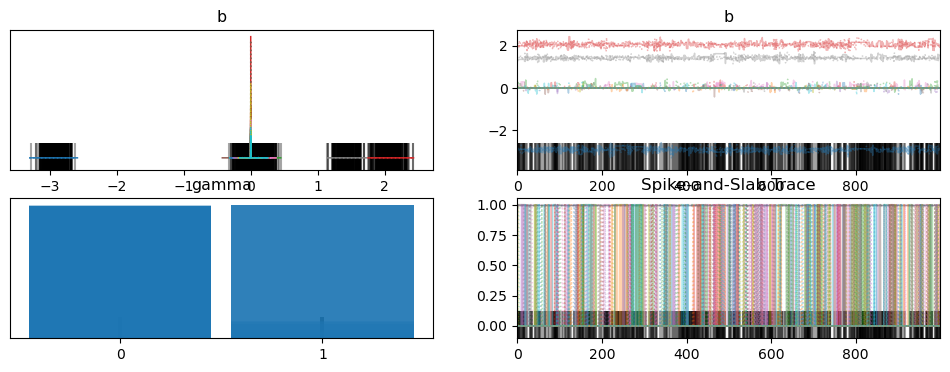

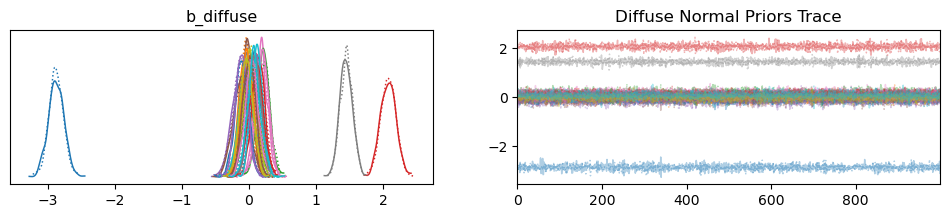

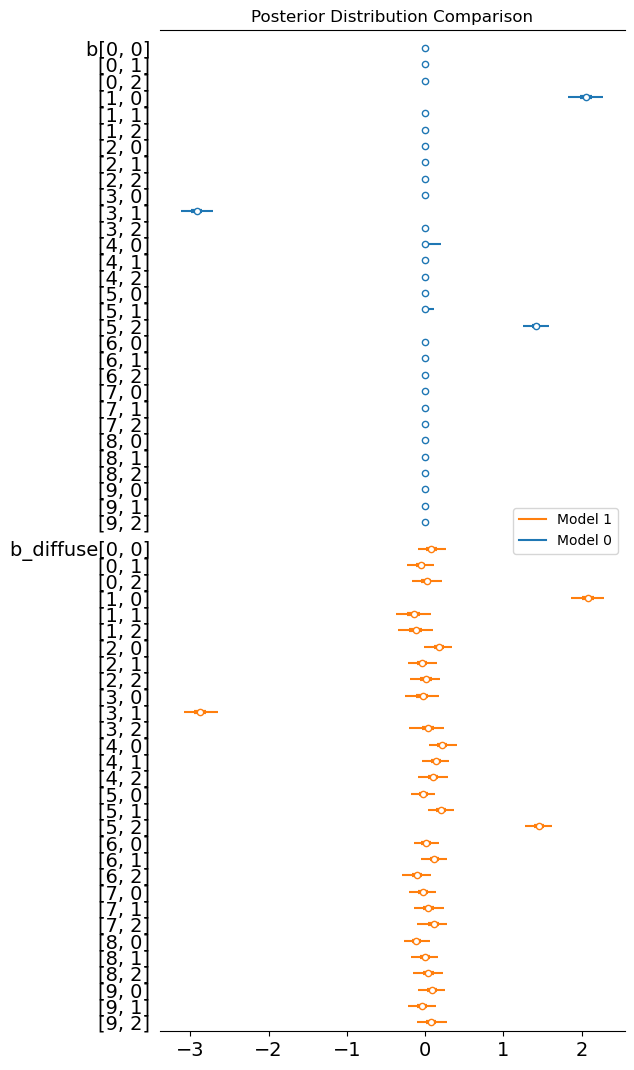

In [7]:
#Q2
# Importing necessary libraries
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import time

# Generate synthetic data
np.random.seed(1007818630)
n = 100   # number of observations
p = 10    # number of predictors (columns of X)
m = 3     # number of response variables

# Design matrix X with n observations and p predictors
X = np.random.normal(0, 1, (n, p))

# True coefficients: many are zero, few nonzero (for variable selection)
true_b = np.zeros((p, m))
true_b[1, 0] = 2.0
true_b[3, 1] = -3.0
true_b[5, 2] = 1.5

# Generate responses Y with noise
Y = X @ true_b + np.random.normal(0, 1, (n, m))

# Spike-and-Slab Model
start_time_spike = time.time()

with pm.Model() as spike_slab_model:
    # Inclusion indicators (gamma) for each coefficient
    gamma = pm.Bernoulli('gamma', p=0.5, shape=(p, m))
    
    # Slab: diffuse Normal priors for coefficients when included
    b_slab = pm.Normal('b_slab', mu=0, sigma=10, shape=(p, m))
    
    # Spike-and-Slab: coefficient is 0 if gamma is 0
    b = pm.Deterministic('b', gamma * b_slab)
    
    # Noise standard deviation for each response
    sigma = pm.HalfNormal('sigma', sigma=1, shape=m)
    
    # Linear predictor
    mu = pm.math.dot(X, b)
    
    # Likelihood
    Y_obs = pm.Normal('Y_obs', mu=mu, sigma=sigma, observed=Y)
    
    # Sampling
    idata_spike = pm.sample(1000, tune=1000, cores=2, random_seed=1007818630)

end_time_spike = time.time()

# Diffuse Normal Priors Model
start_time_diffuse = time.time()

with pm.Model() as diffuse_model:
    # Diffuse normal priors with large variance
    b_diffuse = pm.Normal('b_diffuse', mu=0, sigma=1000, shape=(p, m))
    
    sigma_diffuse = pm.HalfNormal('sigma_diffuse', sigma=1, shape=m)
    
    mu_diffuse = pm.math.dot(X, b_diffuse)
    
    # Likelihood
    Y_obs_diffuse = pm.Normal('Y_obs_diffuse', mu=mu_diffuse, sigma=sigma_diffuse, observed=Y)
    
    # Sampling
    idata_diffuse = pm.sample(1000, tune=1000, cores=2, random_seed=1007818630)

end_time_diffuse = time.time()

# Compare results
print(f"Spike-and-Slab model runtime: {end_time_spike - start_time_spike:.2f} seconds")
print(f"Diffuse model runtime: {end_time_diffuse - start_time_diffuse:.2f} seconds")

# Posterior summary for Spike-and-Slab
print("Spike-and-Slab Model Posterior Summary:")
print(az.summary(idata_spike, var_names=['b', 'gamma']))

# Posterior summary for Diffuse Normal Priors
print("Diffuse Normal Priors Model Posterior Summary:")
print(az.summary(idata_diffuse, var_names=['b_diffuse']))

# Plot trace plots
az.plot_trace(idata_spike, var_names=['b', 'gamma'])
plt.title("Spike-and-Slab Trace")
plt.show()

az.plot_trace(idata_diffuse, var_names=['b_diffuse'])
plt.title("Diffuse Normal Priors Trace")
plt.show()

# Posterior density comparison
az.plot_forest([idata_spike, idata_diffuse], var_names=['b', 'b_diffuse'], combined=True)
plt.title("Posterior Distribution Comparison")
plt.show()


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau, lam, beta_hs, sigma_hs]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 41 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>BinaryGibbsMetropolis: [gamma]
>NUTS: [b_slab, sigma_ss]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 42 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Horseshoe model runtime: 43.85 seconds
Spike-and-Slab model runtime: 44.00 seconds

Horseshoe Model Posterior Summary:
                mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
beta_hs[0, 0]  0.029  0.057  -0.066    0.157      0.002    0.002     739.0   
beta_hs[0, 1] -0.009  0.054  -0.122    0.093      0.002    0.003     522.0   
beta_hs[0, 2]  0.007  0.047  -0.082    0.115      0.002    0.003     605.0   
beta_hs[1, 0]  2.052  0.112   1.846    2.257      0.003    0.004    1144.0   
beta_hs[1, 1] -0.036  0.073  -0.195    0.070      0.004    0.004     599.0   
...              ...    ...     ...      ...        ...      ...       ...   
lam[8, 1]      1.092  1.589   0.010    3.287      0.062    0.154     515.0   
lam[8, 2]      1.279  2.455   0.008    4.052      0.101    0.654     352.0   
lam[9, 0]      1.479  4.287   0.011    3.904      0.114    1.393     568.0   
lam[9, 1]      1.228  2.128   0.012    3.668      0.081    0.354     638.0   
lam[9, 2]      1.336  2

/opt/conda/lib/python3.11/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/opt/conda/lib/python3.11/site-packages/arviz/stats/diagnostics.py:991: RuntimeWarning: invalid value encountered in scalar divide
  varsd = varvar / evar / 4
/opt/conda/lib/python3.11/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/opt/conda/lib/python3.11/site-packages/arviz/stats/diagnostics.py:991: RuntimeWarning: invalid value encountered in scalar divide
  varsd = varvar / evar / 4
/opt/conda/lib/python3.11/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/opt/conda/lib/python3.11/site-pac

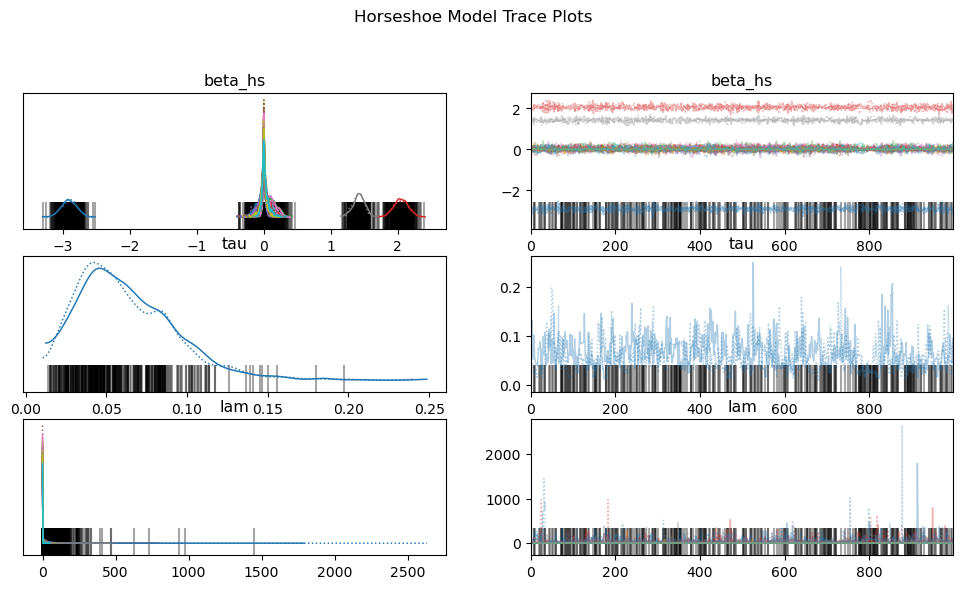

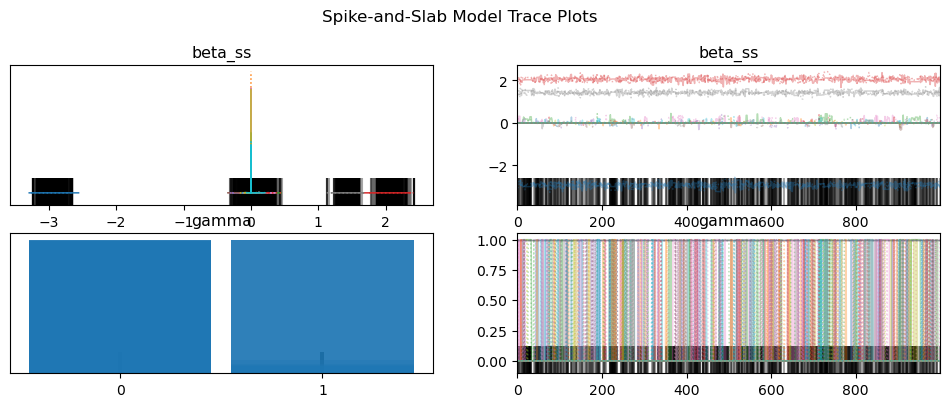

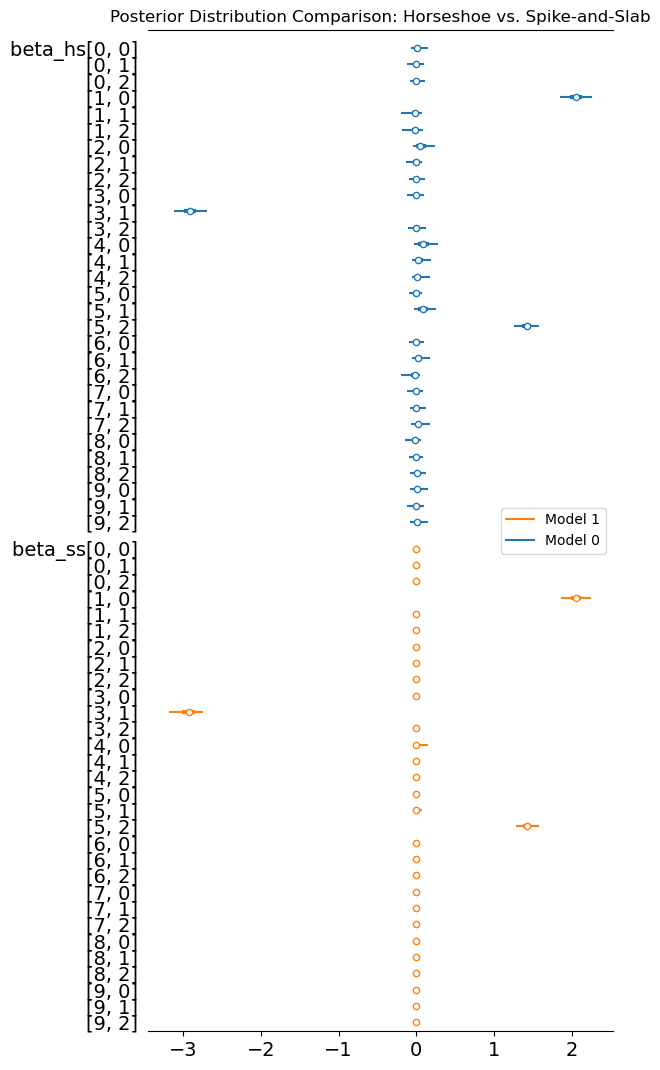

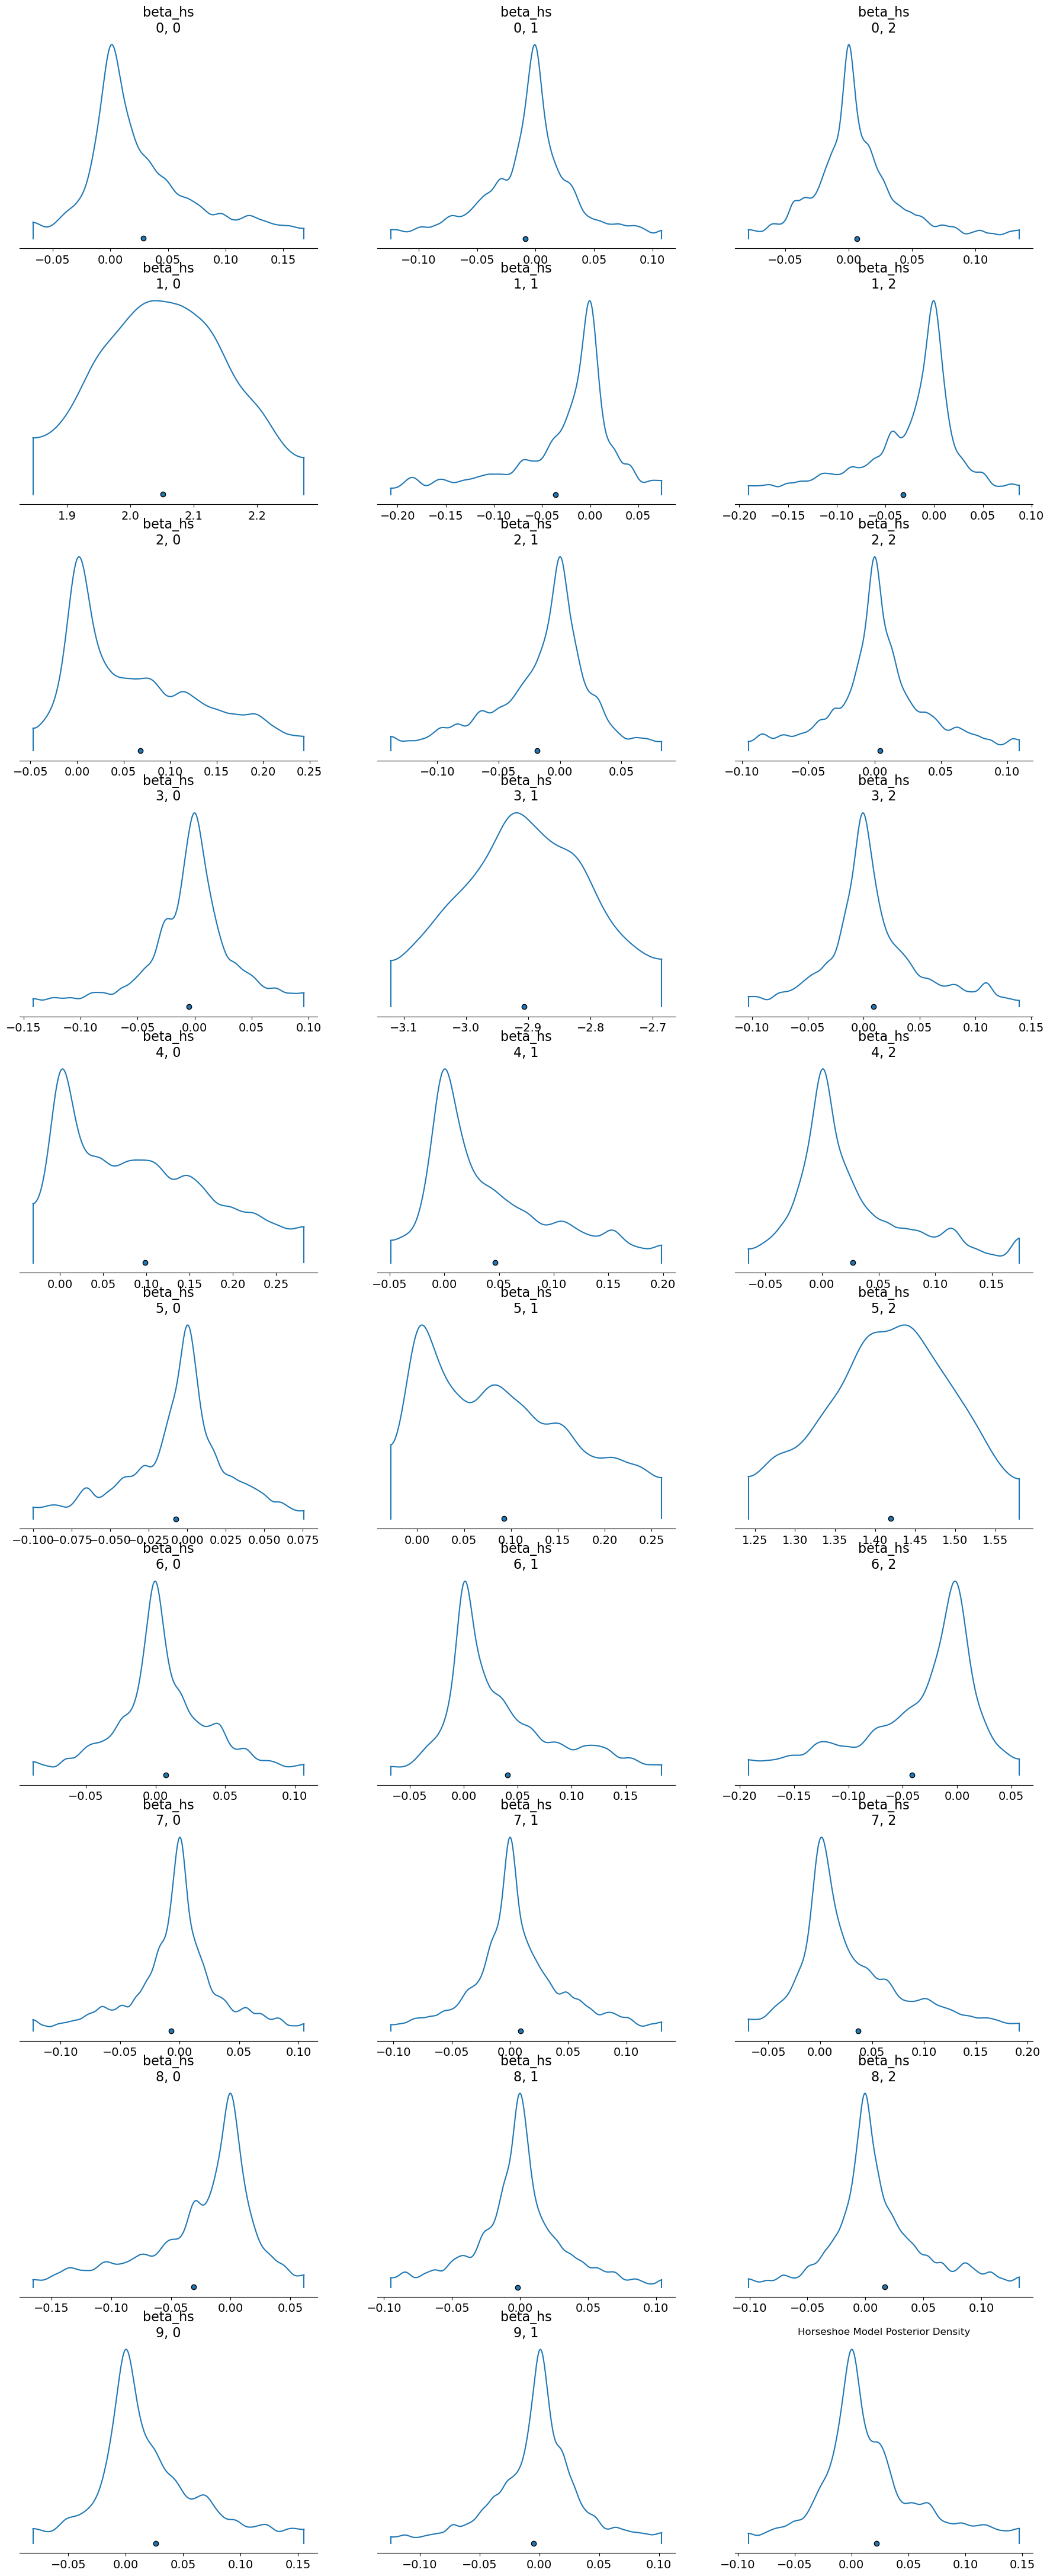

/opt/conda/lib/python3.11/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


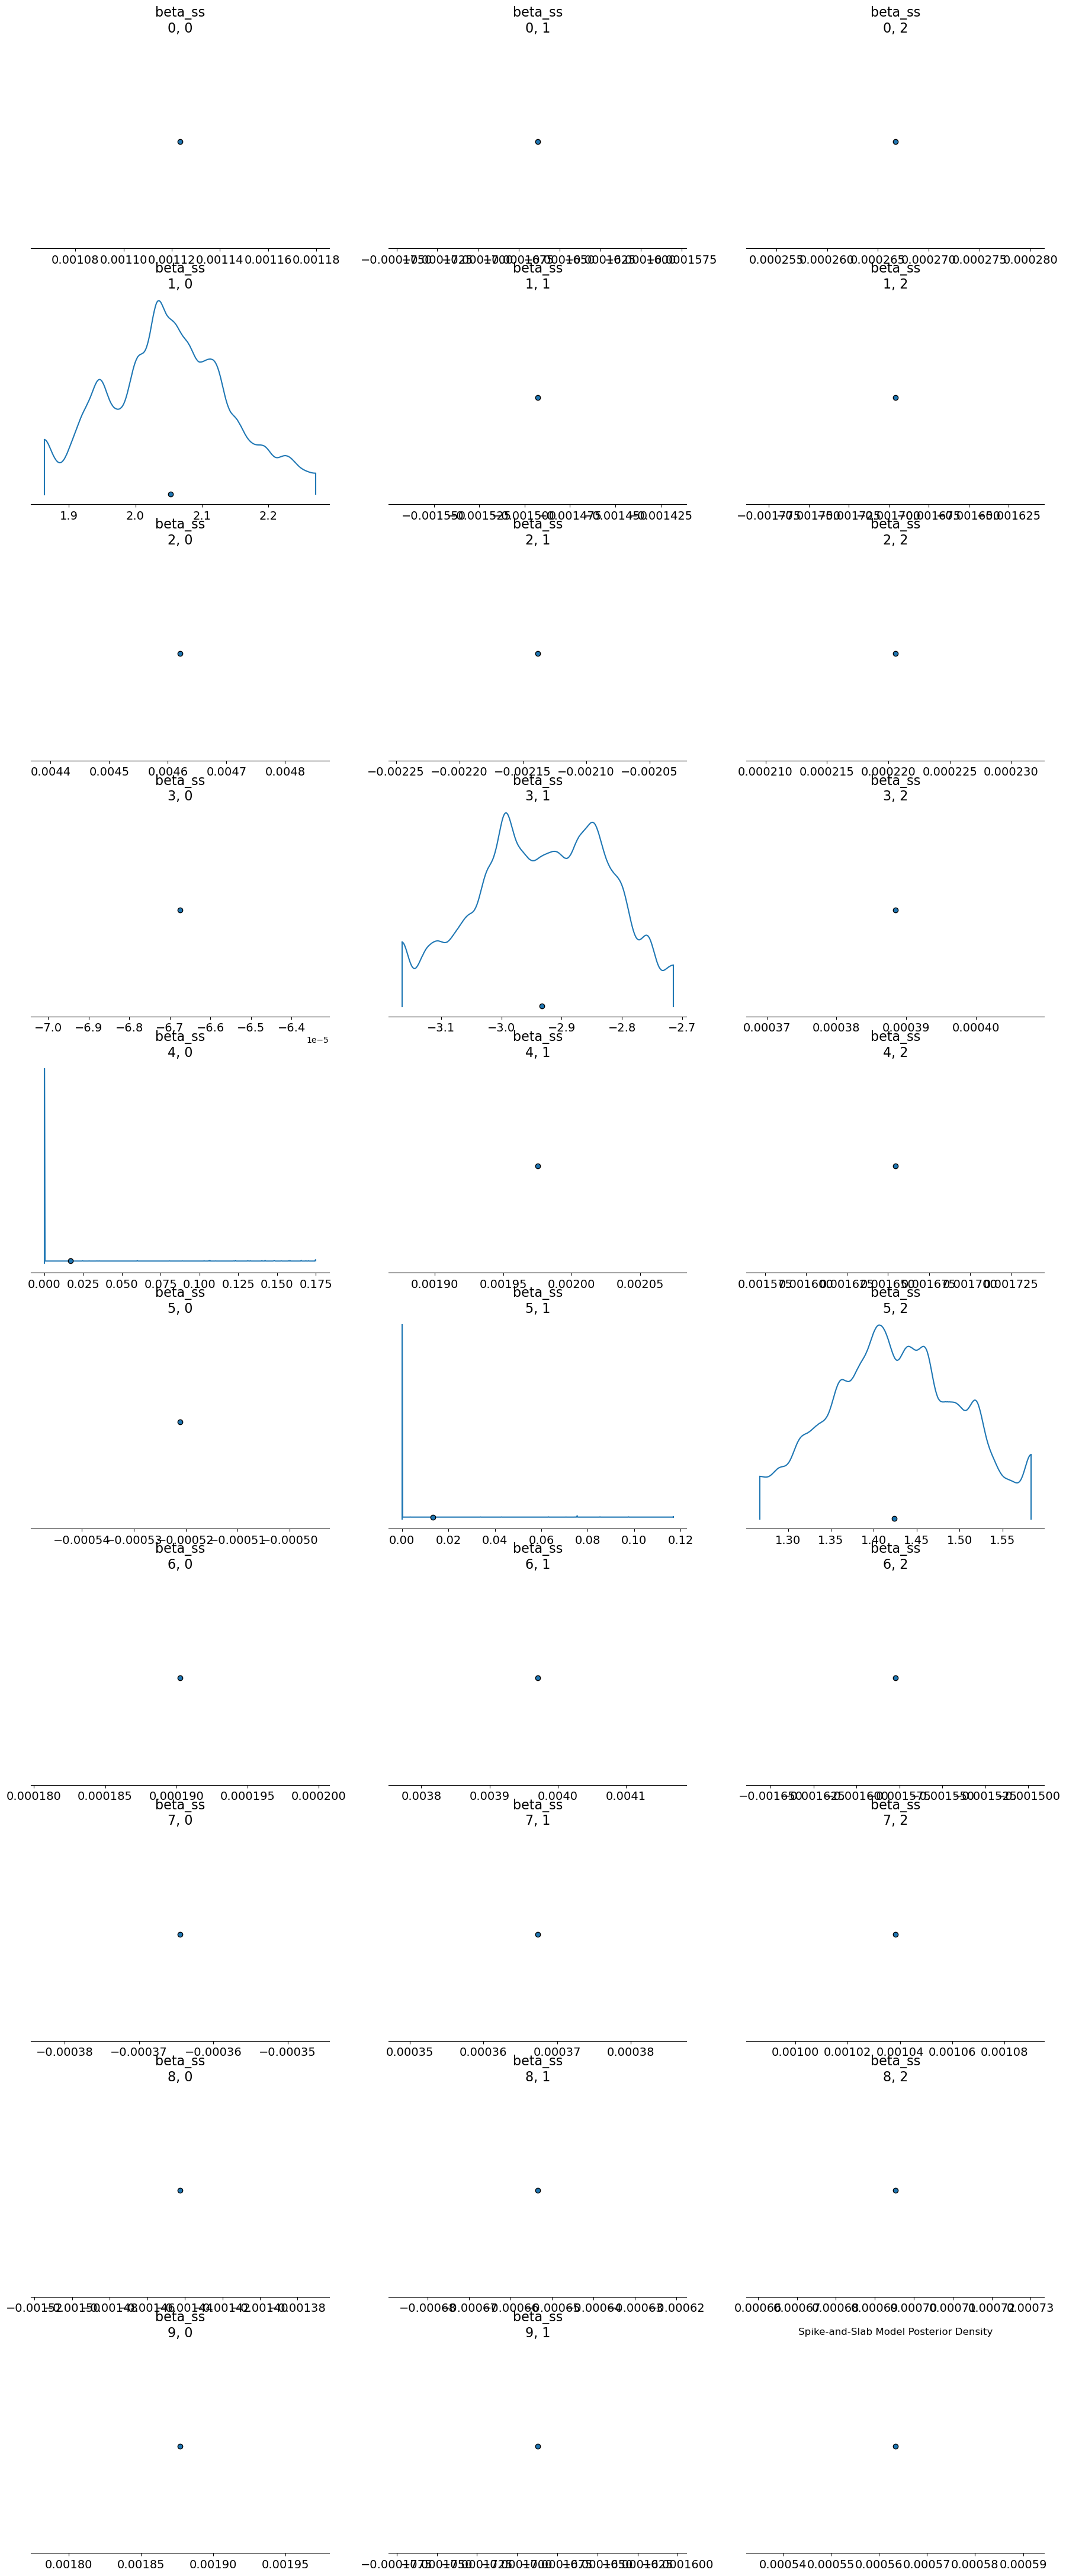

/opt/conda/lib/python3.11/site-packages/arviz/plots/backends/matplotlib/pairplot.py:233: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of resulting pair plots with these variables, generating only a 8x8 grid
  warnings.warn(


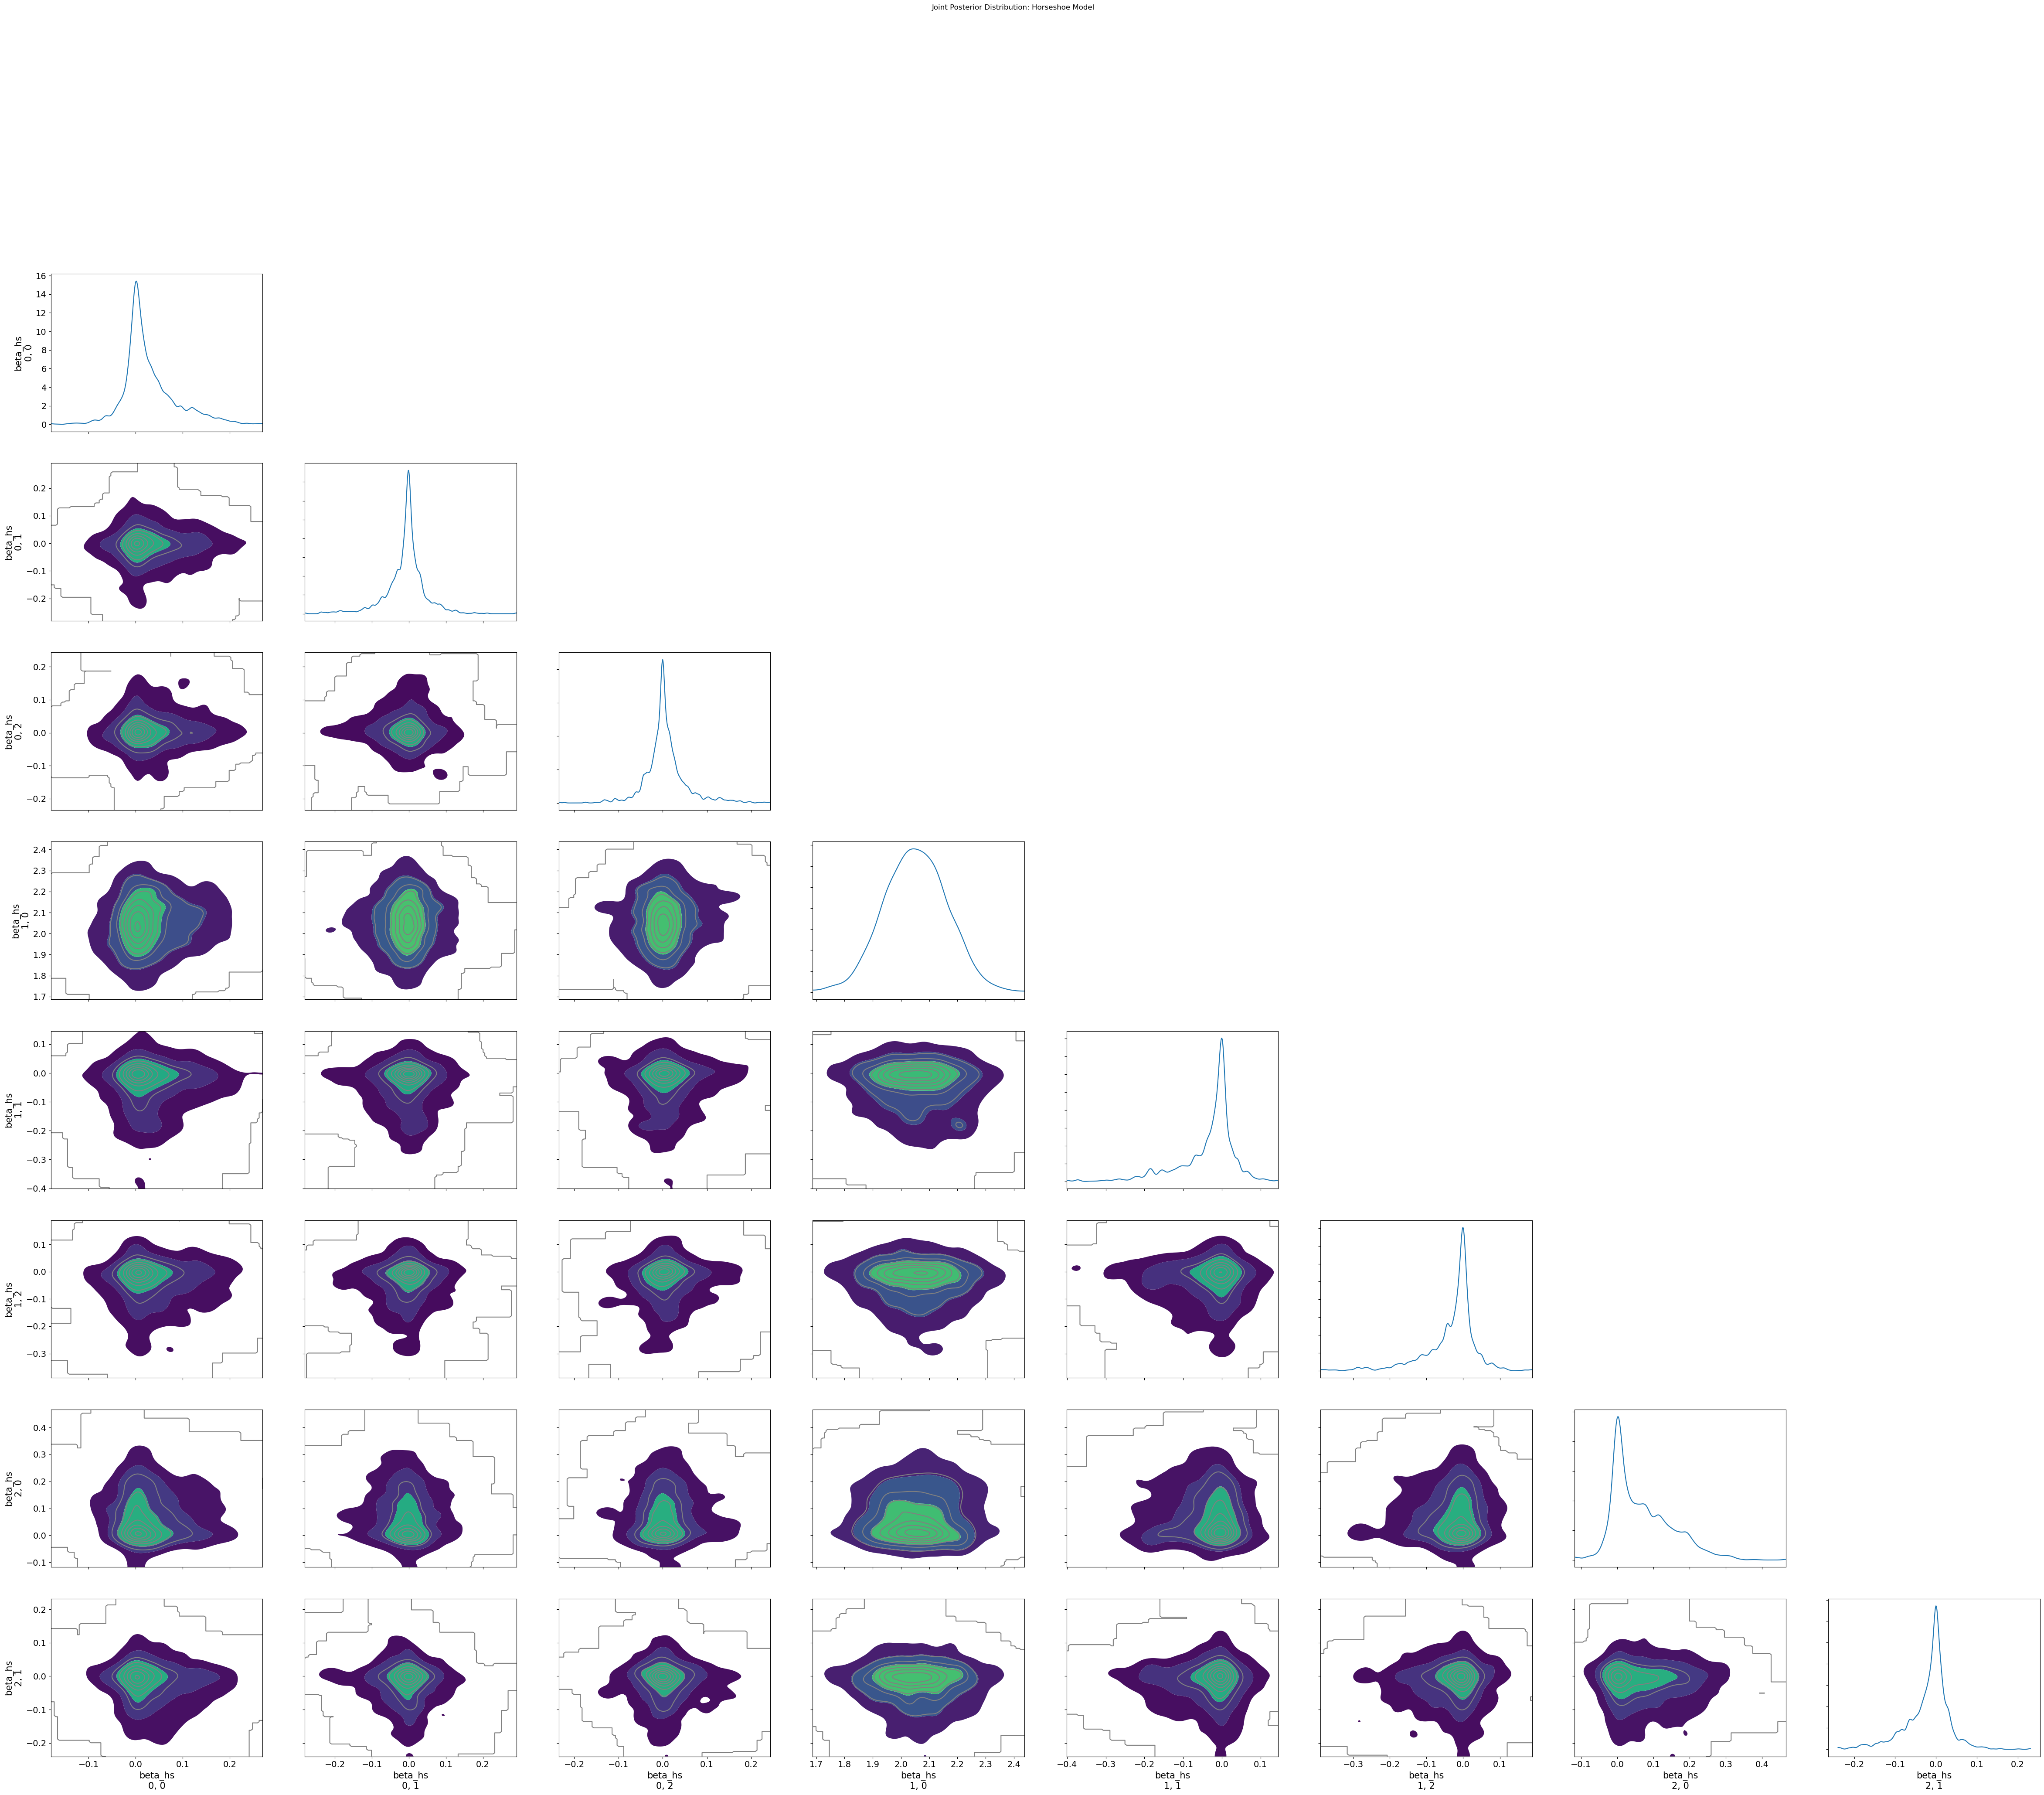

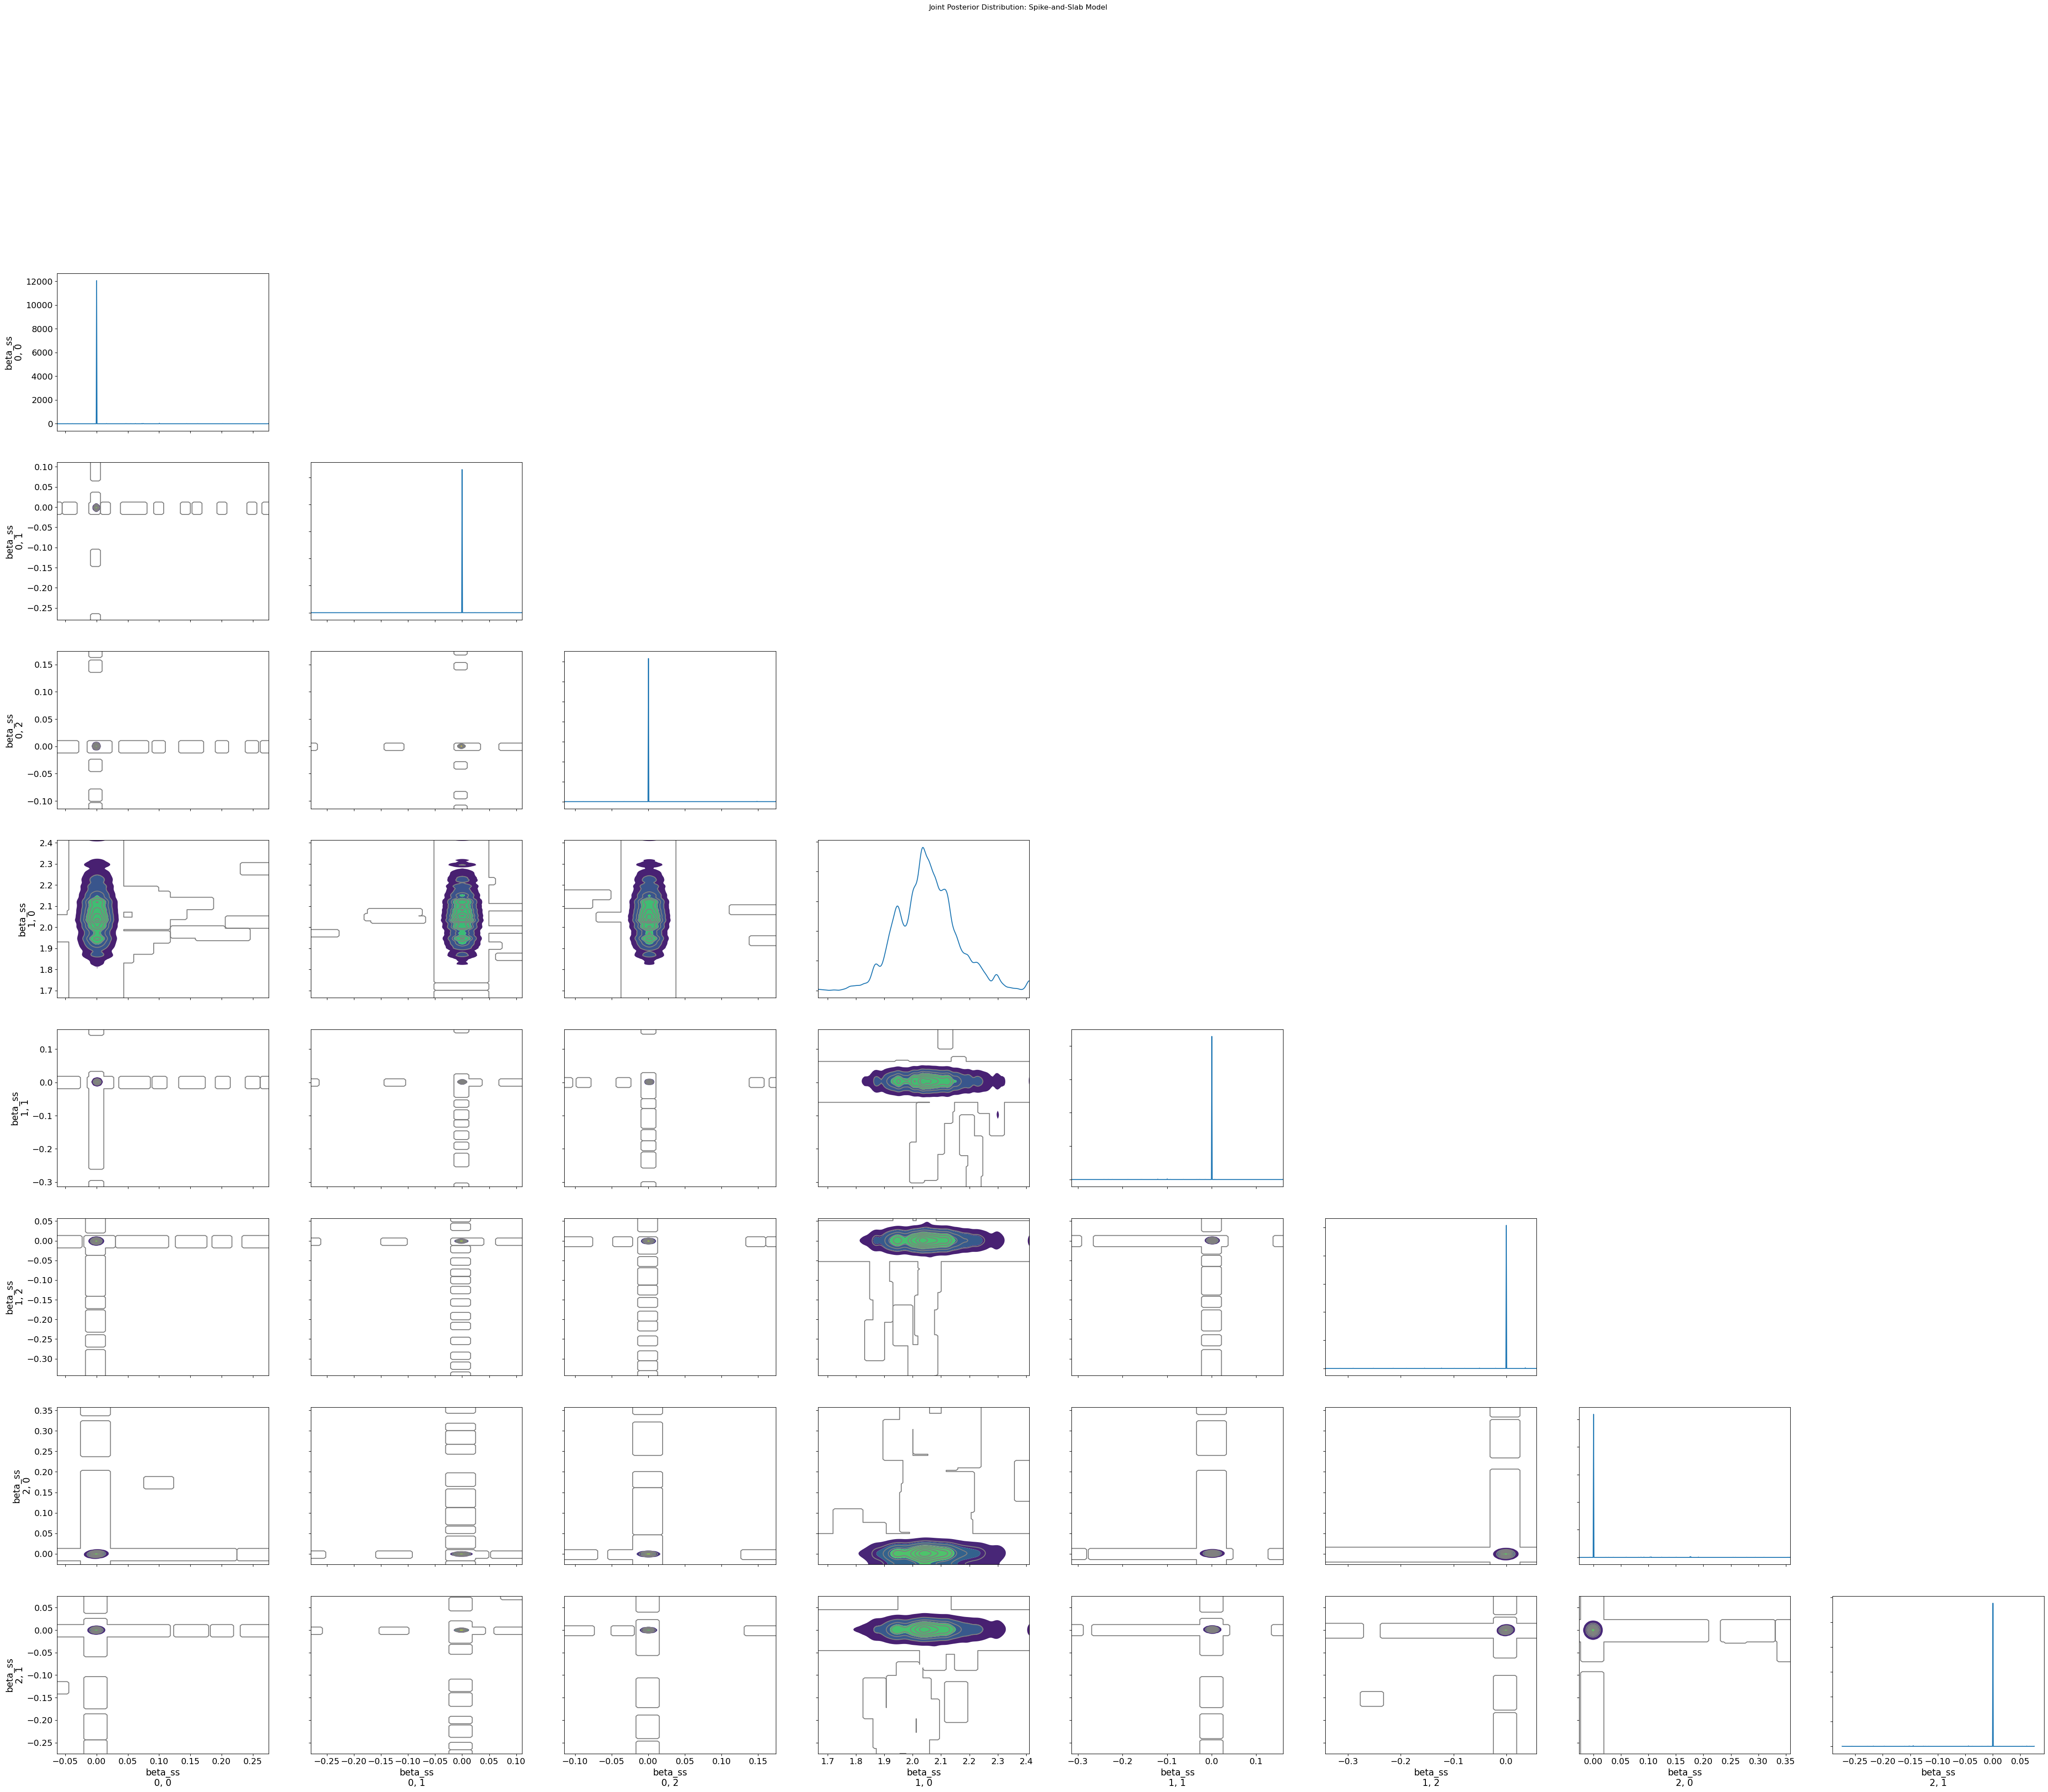

In [10]:
# -------------------------------
# Imports and Configuration
# -------------------------------
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import time

# Global seed for reproducibility
np.random.seed(1007818630)

# -------------------------------
# Generate Synthetic Data
# -------------------------------
n = 100   # number of observations
p = 10    # number of predictors
m = 3     # number of response variables

# Design matrix X
X = np.random.normal(0, 1, (n, p))

# True coefficients: many are zero, few nonzero
true_b = np.zeros((p, m))
true_b[1, 0] = 2.0
true_b[3, 1] = -3.0
true_b[5, 2] = 1.5

# Generate response matrix Y with noise
Y = X @ true_b + np.random.normal(0, 1, (n, m))

# -------------------------------
# Horseshoe Prior Model
# -------------------------------
start_hs = time.time()

with pm.Model() as horseshoe_model:
    # Global scale parameter
    tau = pm.HalfCauchy('tau', beta=1.0)
    # Local scale parameters
    lam = pm.HalfCauchy('lam', beta=1, shape=(p, m))
    # Horseshoe prior for coefficients
    beta_hs = pm.Normal('beta_hs', mu=0, sigma=tau * lam, shape=(p, m))
    # Noise standard deviations
    sigma_hs = pm.HalfNormal('sigma_hs', sigma=1, shape=m)
    # Linear predictor
    mu_hs = pm.math.dot(X, beta_hs)
    # Likelihood
    Y_obs_hs = pm.Normal('Y_obs_hs', mu=mu_hs, sigma=sigma_hs, observed=Y)

    # Sampling with fixed seed
    idata_hs = pm.sample(1000, tune=1000, cores=2, random_seed=1007818630)

end_hs = time.time()

# -------------------------------
# Spike-and-Slab Model
# -------------------------------
start_ss = time.time()

with pm.Model() as spike_slab_model:
    # Inclusion indicators (gamma)
    gamma = pm.Bernoulli('gamma', p=0.5, shape=(p, m))
    # Coefficient slab
    b_slab = pm.Normal('b_slab', mu=0, sigma=10, shape=(p, m))
    # Spike-and-slab combination
    beta_ss = pm.Deterministic('beta_ss', gamma * b_slab)
    # Noise standard deviations
    sigma_ss = pm.HalfNormal('sigma_ss', sigma=1, shape=m)
    # Linear predictor
    mu_ss = pm.math.dot(X, beta_ss)
    # Likelihood
    Y_obs_ss = pm.Normal('Y_obs_ss', mu=mu_ss, sigma=sigma_ss, observed=Y)

    # Sampling with fixed seed
    idata_ss = pm.sample(1000, tune=1000, cores=2, random_seed=1007818630)

end_ss = time.time()

# -------------------------------
# Performance Comparison
# -------------------------------
print(f"Horseshoe model runtime: {end_hs - start_hs:.2f} seconds")
print(f"Spike-and-Slab model runtime: {end_ss - start_ss:.2f} seconds")

# Posterior summaries for both models
print("\nHorseshoe Model Posterior Summary:")
print(az.summary(idata_hs, var_names=['beta_hs', 'tau', 'lam']))

print("\nSpike-and-Slab Model Posterior Summary:")
print(az.summary(idata_ss, var_names=['beta_ss', 'gamma']))

# -------------------------------
# Visualization and Comparison
# -------------------------------

# Trace plots for Horseshoe model
az.plot_trace(idata_hs, var_names=['beta_hs', 'tau', 'lam'])
plt.suptitle("Horseshoe Model Trace Plots", y=1.02)
plt.show()

# Trace plots for Spike-and-Slab model
az.plot_trace(idata_ss, var_names=['beta_ss', 'gamma'])
plt.suptitle("Spike-and-Slab Model Trace Plots", y=1.02)
plt.show()

# Forest plot to compare posterior distributions
az.plot_forest([idata_hs, idata_ss], var_names=['beta_hs', 'beta_ss'], combined=True)
plt.title("Posterior Distribution Comparison: Horseshoe vs. Spike-and-Slab")
plt.show()

# Density plots for coefficients - Horseshoe Model
az.plot_density(idata_hs, var_names=['beta_hs'], hdi_prob=0.95)
plt.title("Horseshoe Model Posterior Density")
plt.show()

# Density plots for coefficients - Spike-and-Slab Model
az.plot_density(idata_ss, var_names=['beta_ss'], hdi_prob=0.95)
plt.title("Spike-and-Slab Model Posterior Density")
plt.show()

# Joint posterior plots for coefficients
az.plot_pair(idata_hs, var_names=['beta_hs'], kind='kde', marginals=True)
plt.suptitle("Joint Posterior Distribution: Horseshoe Model", y=1.02)
plt.show()

az.plot_pair(idata_ss, var_names=['beta_ss'], kind='kde', marginals=True)
plt.suptitle("Joint Posterior Distribution: Spike-and-Slab Model", y=1.02)
plt.show()
